In [85]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import uncertainties
from uncertainties import ufloat, unumpy
from uncertainties.umath import log10
from scipy.odr import ODR, Model, RealData
from scipy.optimize import fsolve, curve_fit
from matplotlib.ticker import AutoMinorLocator, LogLocator
from scipy import constants

In [86]:
resistance = 52.1
dOmega = 0.005 * resistance + 0.1
dOmega

0.36050000000000004

## Propagation velocity

### Coax cable

In [87]:
dt = np.sqrt(2) * 10
T = ufloat(508*1e-9, dt*1e-9)
l = ufloat(50, 0.01)
(2*l/T) / 1e8 # in 10^8 m/s

1.9685039370078738+/-0.05480229933904268

### Delay cable

In [88]:
dt_delay = np.sqrt(2) * 50
T_delay = ufloat(1.78*1e-6, dt*1e-9)
l_delay = ufloat(0.455, 0.02)
(2*l_delay/T_delay) / 1e5 # in 10^8 m/s
# dt_delay / 1e3

5.1123595505617985+/-0.2283604168872041

In [89]:
v_p = (2*l/T)
[(v_p / ((i)*l)) / 1e6 for i in [4/3, 2, 4]]

[2.9527559055118116+/-0.08220132771559158,
 1.968503937007874+/-0.05480088514372772,
 0.984251968503937+/-0.02740044257186386]

## Speed of light

In [90]:
lengths = [3.913, 4.013, 4.113, 7.923, 8.023, 8.123, 11.715, 11.815, 11.915]
times = np.array([20, 24, 24, 56, 55, 59, 82, 84, 86]) * 1e-9

m = (5-10) / (lengths[-1]-lengths[0])
a = 10-m*lengths[0]

errTimes = np.array([np.sqrt(2) * abs(m*i+a)  for i in lengths]) * 1e-9
d = unumpy.uarray(lengths, np.full(len(lengths), np.sqrt(2) * 0.002))
t = unumpy.uarray(times, errTimes)

c = (2 * d / t) / 1e8
c

array([3.913+/-2.766910280439176, 3.3441666666666663+/-1.9582575460078342,
       3.4275+/-1.9944355246343737,
       2.829642857142857+/-0.5355436445467966,
       2.917454545454545+/-0.5575149750798377,
       2.7535593220338974+/-0.4863969555493667,
       2.857317073170732+/-0.25255293742392126,
       2.8130952380952374+/-0.23976487294133655,
       2.770930232558139+/-0.22783159576975812], dtype=object)

In [91]:
def weight_avg(data):
    weights = 1 / unumpy.std_devs(data)**2
    avg = np.sum(unumpy.nominal_values(data)*weights) / np.sum(weights)
    std_err = 1 / np.sqrt(np.sum(weights))
    return f'{avg} ± {std_err}'

In [92]:
weight_avg(c)

'2.820283511406525 ± 0.12508596633341607'

In [93]:
def dampening(U0, U):
    return 20 * log10(U0 / (U0 - U))

In [94]:
U0 = ufloat(5, 0.05)
Us = [ufloat(1.52, 0.1), ufloat(4.4, 0.2), ufloat(2.72, 0.2)]
damp = []
for i in Us:
    value = dampening(U0, i)
    damp.append(value)

print(f'Dampening 0.9MHz: {damp[0]} dB')
print(f'Dampening 2.89MHz: {damp[1]} dB')
print(f'Dampening 1.88MHz: {damp[2]:.2f} dB')

dampening(U0, ufloat(.31,0.07))

Dampening 0.9MHz: 3.15+/-0.25 dB
Dampening 2.89MHz: 18.4+/-3.0 dB
Dampening 1.88MHz: 6.82+/-0.77 dB


0.5559432324187108+/-0.1297672082942505

In [95]:
Vs = np.array([ufloat(188,10), ufloat(192.6,3.3), ufloat(187.9,5.0)]) * 1e6
Fs = np.array([ufloat(0.941,0.05), ufloat(2.889,0.05), ufloat(1.879,0.05)]) * 1e6
Ers = []
for i in Vs:
    value = constants.c**2 / i**2
    Ers.append(value)

print(f'Er 0.9MHz: {Ers[0]}')
print(f'Er 2.89MHz: {Ers[1]}')
print(f'Er 1.88MHz: {Ers[2]:.2f}')

Er 0.9MHz: 2.54+/-0.27
Er 2.89MHz: 2.42+/-0.08
Er 1.88MHz: 2.55+/-0.14


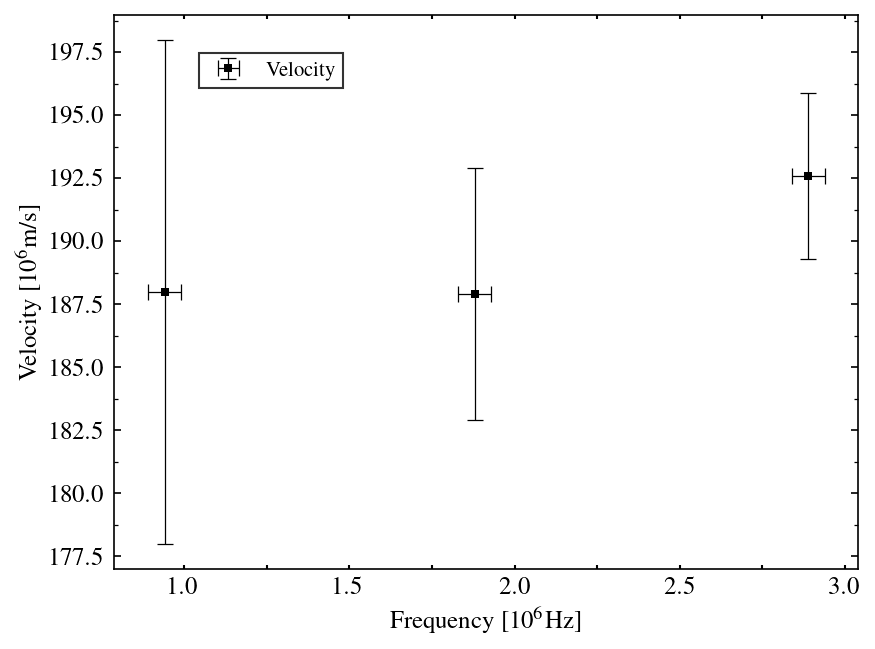

In [96]:
fig, ax = plt.subplots(dpi=150)

plt.rcParams["font.family"] = "times"
plt.rcParams["text.usetex"] = True


ax.errorbar(unumpy.nominal_values(Fs) / 1e6, unumpy.nominal_values(Vs) / 1e6,
            capsize=4,
            xerr=unumpy.std_devs(Fs) / 1e6, yerr=unumpy.std_devs(Vs) / 1e6,
            ecolor='black',
            elinewidth=.6,
            capthick=.6,
            markersize=4, fmt="s",
            markeredgecolor='none', c="black",
            label=f'Velocity',
            zorder=2)
# ax.set_xlim(5, 8.5)

ax.set_ylabel(r'Velocity [$10^{6}$m/s]', fontsize=12)
ax.set_xlabel(r'Frequency [$10^{6}$Hz]', fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(axis='x', which='both',direction='in', labelsize=12, width=1, length=2, bottom=True, top=True)
ax.tick_params(axis='y', which='both',direction='in', labelsize=12, left=True, right=True)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0]  

plt.legend([handles[idx] for idx in order],
        [labels[idx] for idx in order],
        loc="upper left",
        bbox_to_anchor=(0.1, 0.95),
        fancybox=False,
        edgecolor='black',
        fontsize=10)
plt.show()

# fig.savefig('/Users/danielmiksch/Library/CloudStorage/OneDrive-Persönlich/Uni/C-Praktikum/C41/dispersion.pdf')

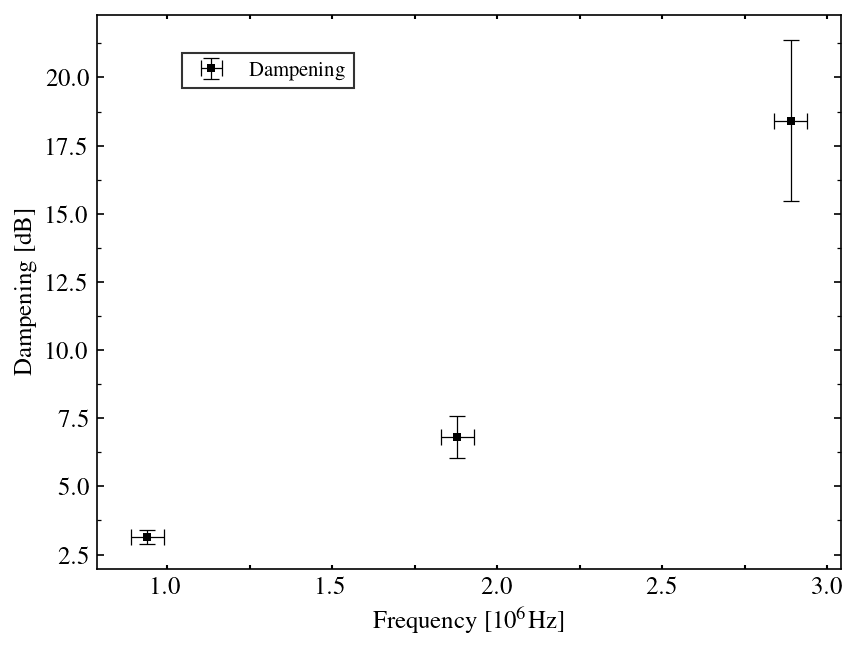

In [97]:
fig, ax = plt.subplots(dpi=150)

plt.rcParams["font.family"] = "times"
plt.rcParams["text.usetex"] = True


ax.errorbar(unumpy.nominal_values(Fs) / 1e6, unumpy.nominal_values(damp),
            capsize=4,
            xerr=unumpy.std_devs(Fs) / 1e6, yerr=unumpy.std_devs(damp),
            ecolor='black',
            elinewidth=.6,
            capthick=.6,
            markersize=4, fmt="s",
            markeredgecolor='none', c="black",
            label=f'Dampening',
            zorder=2)
# ax.set_xlim(5, 8.5)

ax.set_ylabel(r'Dampening [dB]', fontsize=12)
ax.set_xlabel(r'Frequency [$10^{6}$Hz]', fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(axis='x', which='both',direction='in', labelsize=12, width=1, length=2, bottom=True, top=True)
ax.tick_params(axis='y', which='both',direction='in', labelsize=12, left=True, right=True)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0]  

plt.legend([handles[idx] for idx in order],
        [labels[idx] for idx in order],
        loc="upper left",
        bbox_to_anchor=(0.1, 0.95),
        fancybox=False,
        edgecolor='black',
        fontsize=10)
plt.show()

fig.savefig('/Users/danielmiksch/Library/CloudStorage/OneDrive-Persönlich/Uni/C-Praktikum/C41/dampening.pdf')

In [98]:
def lin(x, a):
    return a*x

In [111]:
popt, pcov = curve_fit(lin, unumpy.nominal_values(t), unumpy.nominal_values(d) * 2, sigma=unumpy.std_devs(d), absolute_sigma=True)
print(f'Speed of light: ({ufloat(popt[0], pcov[0])/1e8:.1f}) * 10^8 m/s')

Speed of light: (2.9+/-2.5) * 10^8 m/s


In [109]:
def linear(p, x):
    B = p
    return B*x

model_lin = Model(linear)
data_lin = RealData(x=unumpy.nominal_values(t), y=unumpy.nominal_values(d) * 2, sx=unumpy.std_devs(t), sy=unumpy.std_devs(d))
odrLin = ODR(data_lin, model_lin, beta0=[2.8*1e8])
lin_output = odrLin.run()
lin_output.pprint()


Beta: [2.82929382e+08]
Beta Std Error: [3582016.45307748]
Beta Covariance: [[1.57531358e+14]]
Residual Variance: 0.08144944622738125
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


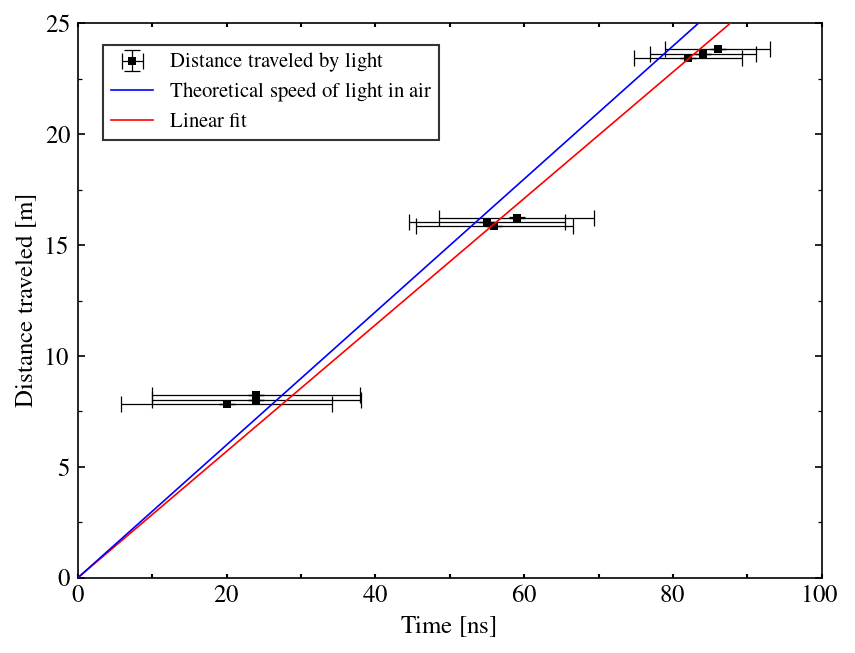

In [112]:
fig, ax = plt.subplots(dpi=150)

plt.rcParams["font.family"] = "times"
plt.rcParams["text.usetex"] = True

x = np.linspace(0,100,1000)

ax.errorbar(unumpy.nominal_values(t) * 1e9, unumpy.nominal_values(d) * 2,
            capsize=4,
            xerr=unumpy.std_devs(t) * 1e9, yerr=unumpy.std_devs(d),
            ecolor='black',
            elinewidth=.6,
            capthick=.6,
            markersize=4, fmt="s",
            markeredgecolor='none', c="black",
            label=f'Distance traveled by light',
            zorder=2)

ax.set_xlim(0, 100)
ax.set_ylim(0, 25)

ax.plot(x, lin(x, popt[0]) / 1e9,
        c='red',
        linewidth=.8,
        label='Linear fit',
        zorder=3)
ax.plot(x, lin(x, constants.c) / 1e9,
        c='blue',
        linewidth=.8,
        label='Theoretical speed of light in air',
        zorder=3)

ax.set_ylabel(r'Distance traveled [m]', fontsize=12)
ax.set_xlabel(r'Time [ns]', fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(axis='x', which='both',direction='in', labelsize=12, width=1, length=2, bottom=True, top=True)
ax.tick_params(axis='y', which='both',direction='in', labelsize=12, left=True, right=True)

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,1,0]  

plt.legend([handles[idx] for idx in order],
        [labels[idx] for idx in order],
        loc="upper left",
        bbox_to_anchor=(0.02, 0.98),
        fancybox=False,
        edgecolor='black',
        fontsize=10)
plt.show()

fig.savefig('/Users/danielmiksch/Library/CloudStorage/OneDrive-Persönlich/Uni/C-Praktikum/C41/SoL.pdf')

In [132]:
rho = 2.6795 * 1e3
c11 = 1.068 * 1e11
c12 = 0.607 * 1e11
c44 = 0.282 * 1e11
phi1 = np.radians(0)
phi2 = np.radians(45)

In [133]:
v3 = np.sqrt(c44/rho)
v2_phi0 = 1/(2*np.sqrt(rho)) * (2*(c11+c44) - np.sqrt(2)*((1+np.cos(4*phi1))*c11**2+2*np.sin(2*phi1)**2*c12**2+4*c44*(np.sin(2*phi1)**2*c12-np.cos(2*phi1)**2*c11)+2*c44**2)**0.5)**0.5
v1_phi0 = 1/(2*np.sqrt(rho)) * (2*(c11+c44) + np.sqrt(2)*((1+np.cos(4*phi1))*c11**2+2*np.sin(2*phi1)**2*c12**2+4*c44*(np.sin(2*phi1)**2*c12-np.cos(2*phi1)**2*c11)+2*c44**2)**0.5)**0.5

In [134]:
v2_phi45 = 1/(2*np.sqrt(rho)) * (2*(c11+c44) - np.sqrt(2)*((1+np.cos(4*phi2))*c11**2+2*np.sin(2*phi2)**2*c12**2+4*c44*(np.sin(2*phi2)**2*c12-np.cos(2*phi2)**2*c11)+2*c44**2)**0.5)**0.5
v1_phi45 = 1/(2*np.sqrt(rho)) * (2*(c11+c44) + np.sqrt(2)*((1+np.cos(4*phi2))*c11**2+2*np.sin(2*phi2)**2*c12**2+4*c44*(np.sin(2*phi2)**2*c12-np.cos(2*phi2)**2*c11)+2*c44**2)**0.5)**0.5

In [135]:
print(f'v longitudinal (0°) = {v1_phi0} m/s')
print(f'v longitudinal (45°) = {v1_phi45} m/s')
print()
print(f'v transversal 1 (0°) = {v2_phi0} m/s')
print(f'v transversal 1 (45°) = {v2_phi45} m/s')
print()
print(f'v transversal 2 = {v3} m/s')

v longitudinal (0°) = 6313.333707062733 m/s
v longitudinal (45°) = 6463.759190280716 m/s

v transversal 1 (0°) = 3244.1257001118984 m/s
v transversal 1 (45°) = 2932.9765060297636 m/s

v transversal 2 = 3244.1257001118984 m/s


In [141]:
beta90 = np.radians(90)
beta45 = np.radians(45)
cw = 1476.4885251163537
alpha_long = np.arcsin(np.sin(beta90)*(cw/v1_phi45))
alpha_trans45 = np.arcsin(np.sin(beta45)*(cw/v2_phi0))
alpha_trans90 = np.arcsin(np.sin(beta90)*(cw/v3))

In [142]:
print(f'α long = {np.degrees(alpha_long)}°')
print(f'α trans 45° = {np.degrees(alpha_trans45)}°')
print(f'α trans 90° = {np.degrees(alpha_trans90)}°')

α long = 13.204402076309188°
α trans 45° = 18.773222691612816°
α trans 90° = 27.07309259229931°
